In [1]:
import sys
sys.path.append('../lib')
sys.path.append('../analysis')

import numpy as np
import pandas as pd

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist, std_color_list
from gridVarQ2Plot import col_dic, label_dic

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + 'Simulation Internal'
expectedLumi = {'Low':6.4, 'Mid':20.7, 'High':26.4, 'Single':20.7} #fb^-1

Welcome to JupyROOT 6.12/07


In [2]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [3]:
def effProd(e1, e2):
    e = e1[0]*e2[0]
    de = e*np.hypot(e1[1]/e1[0], e2[1]/e2[0])
    return [e, de]

In [4]:
df = {}
hPre = {}
eff = {}

dsMu = DSetLoader('B0_MuNuDmst_PUc0')
dsTau = DSetLoader('B0_TauNuDmst_PUc0')

files = {}
for cat in ['low', 'mid', 'high']:
    fn = '/'+cat.capitalize()+'_corr.root'
    
    df['mu'+cat] = pd.DataFrame(rtnp.root2array(dsMu.skimmed_dir+fn, branches=['N_vtx']))
    f = rt.TFile(dsMu.skimmed_dir+fn, 'READ')
    hPre['mu'+cat] = f.Get('hAllNvtx')
    eff['mu'+cat] = effProd(dsMu.effCand['effCAND'], dsMu.getSkimEff(cat.capitalize()+'_corr'))
    files['mu'+cat] = f
    
    df['tau'+cat] = pd.DataFrame(rtnp.root2array(dsTau.skimmed_dir+fn, branches=['N_vtx']))
    f = rt.TFile(dsTau.skimmed_dir+fn, 'READ')
    hPre['tau'+cat] = f.Get('hAllNvtx')
    eff['tau'+cat] = effProd(dsTau.effCand['effCAND'], dsTau.getSkimEff(cat.capitalize()+'_corr'))
    files['tau'+cat] = f

# General plots

In [5]:
txt = rt.TLatex()
txt.SetTextSize(0.04)
txt.SetTextFont(42)

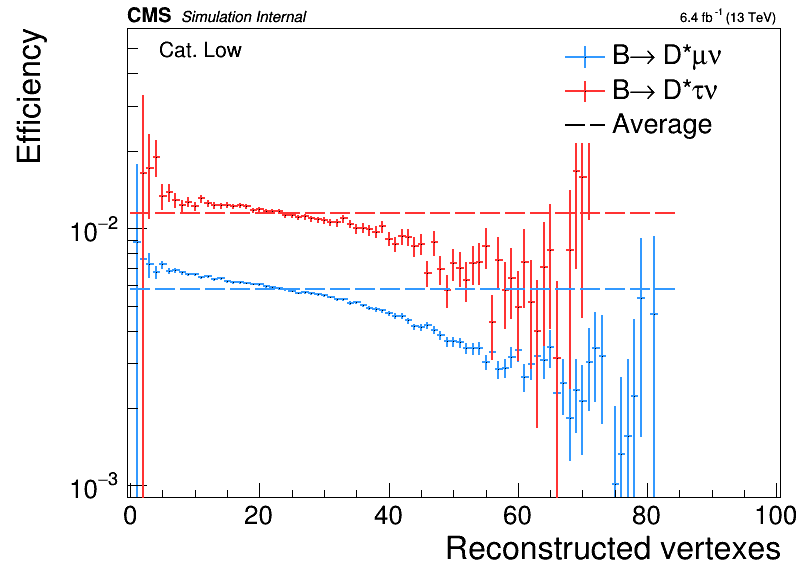

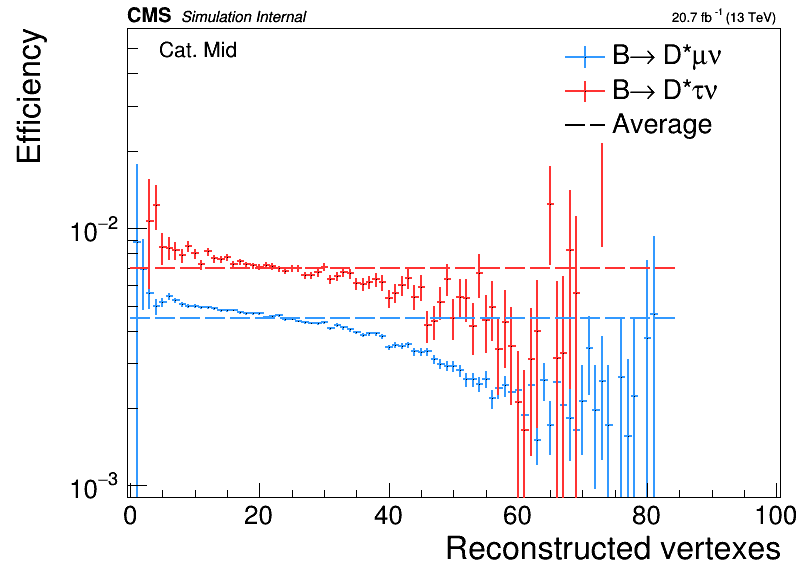

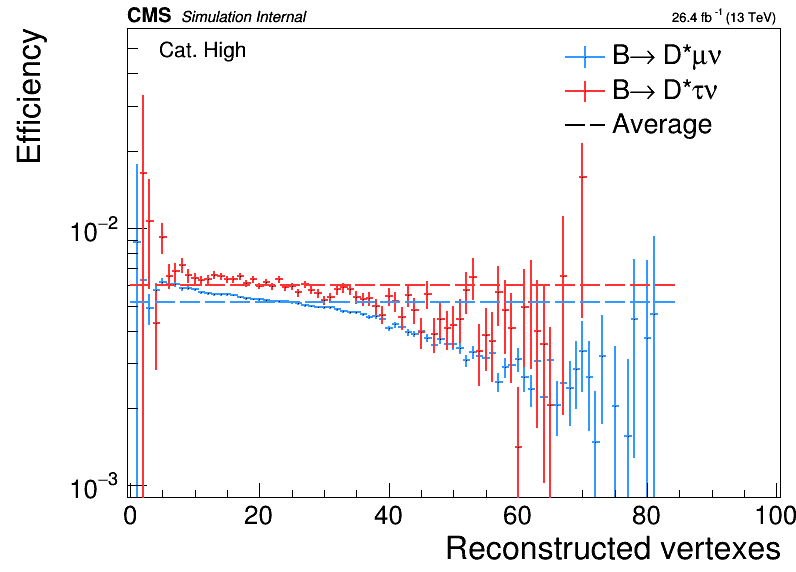

In [15]:
canvases = {}
for cat in ['low', 'mid', 'high']:
    CMS_lumi.integrated_lumi = expectedLumi[cat.capitalize()]
    leg = rt.TLegend(0.7, 0.75, 0.98, 0.93)
    leg.SetTextFont(42)
    leg.SetTextAlign(12)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    hr = {}
    for s in ['mu', 'tau']:
        n = s+cat
        hPre[n].Sumw2()
        hr[n] = create_TH1D(df[n]['N_vtx'], name='hsel'+n, h2clone=hPre[n], 
                            axis_title=['Reconstructed vertexes', 'Efficiency'])
        hr[n].Sumw2()
        hr[n].SetLineColor(col_dic[s])
        hr[n].Divide(hPre[n])
        leg.AddEntry(hr[n], label_dic[s], 'lep')
        label_dic

    hr.values()[0].GetYaxis().SetRangeUser(9e-4, 6e-2)

    canvases[cat] = drawOnCMSCanvas(CMS_lumi, hr.values(), 'same', tag=cat)

    for s in ['mu', 'tau']:
        n = s+cat
        cl.SetLineColor(col_dic[s])
        cl.DrawLine(0, eff[n][0], 85, eff[n][0])
    cl.SetLineColor(1)
    leg.AddEntry(cl, 'Average', 'l')

    txt.DrawLatexNDC(0.2, 0.9, 'Cat. '+cat.capitalize())

    canvases[cat].SetLogy()
    leg.Draw()
    canvases[cat].dnd = [leg, hr]
    canvases[cat].SaveAs('../data/fig/effiencyVSpileup_'+cat+'_MC.png')